In [1]:
import numpy as np
import os
import random
import torch

from torch.utils.data import DataLoader, random_split
from torchvision import transforms

from Callbacks import EarlyStopping
from TransferLearningModel import TransferLearningModel
from utils import DicomCoarseDataset3D

In [2]:
BASE_DIR = "C:/Users/Dominik Hahn/OneDrive/Studium/Master/Masterarbeit/Daten"
# BASE_DIR = "C:/Users/domin/OneDrive/Studium/Master/Masterarbeit/Daten"
seed = 41
batch_size = 32
image_size = 80 #best yet 80 with 87%
classes = ["nodule", "non-nodule"]
train_ratio = 0.6

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

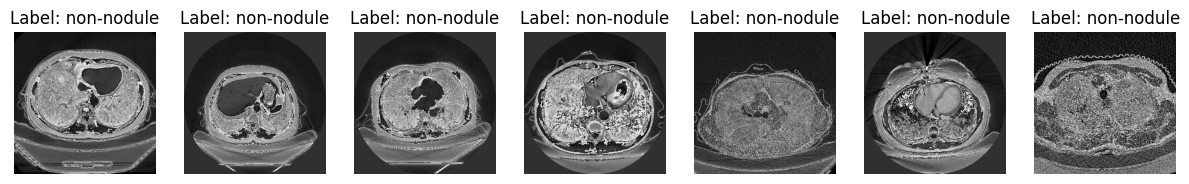

In [3]:
# dataset = DicomCoarseDataset3D(root_dir=BASE_DIR, num_images_per_class=len(os.listdir(os.path.join(BASE_DIR, "nodule"))), classes=classes, scenario=1)
dataset = DicomCoarseDataset3D(root_dir=BASE_DIR, num_images_per_class=100, classes=classes, scenario=1)
dataset.visualize_volumes(num_volumes=7)

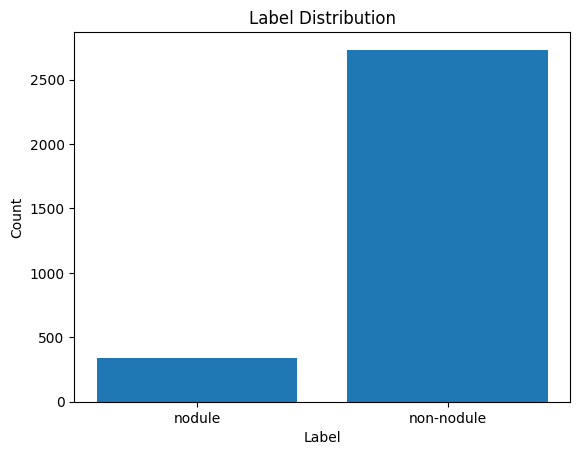

In [4]:
dataset.display_label_distribution()

In [5]:
train_size = int(train_ratio * len(dataset))
val_size = int(((1-train_ratio)/2) * len(dataset)) 
test_size = len(dataset) - train_size - val_size

print(f"Train size: {train_size} --- Validation size: {val_size} --- Test size: {test_size}")

Train size: 1845 --- Validation size: 615 --- Test size: 615


In [6]:
print("Processing model: 3D-CNN")
current_model = TransferLearningModel(classes, "3dcnn")

# Ensure transforms are correctly applied based on model requirements
current_model.train_transforms, current_model.test_transforms = current_model.get_transforms()
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Apply specific transforms to each subset
train_dataset.dataset.transform = current_model.train_transforms
val_dataset.dataset.transform = current_model.test_transforms
test_dataset.dataset.transform = current_model.test_transforms

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize early stopping
early_stopping = EarlyStopping(patience=10)

# Train the current model
current_model.train(train_loader, val_loader, early_stopping, epochs=50)

Processing model: 3D-CNN


TypeError: 'tuple' object is not callable

Best model: efficientnet


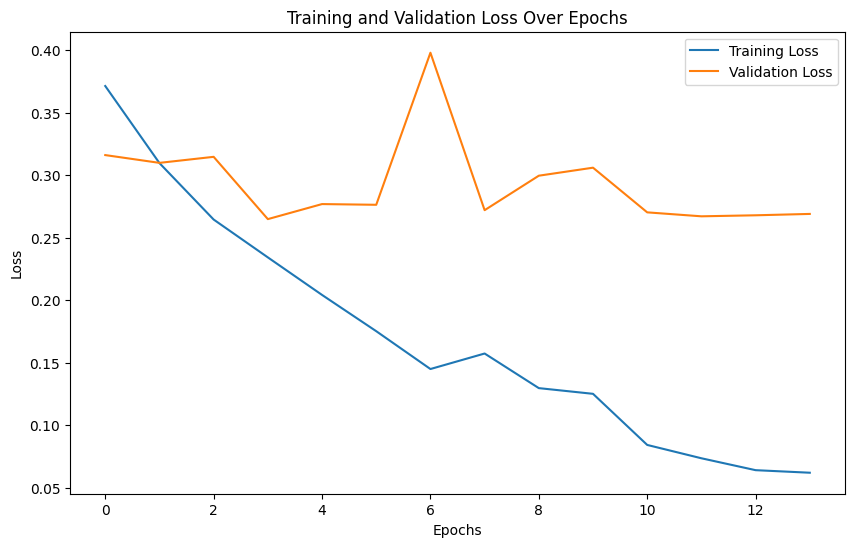

In [ ]:
print(f"Best model: {best_model.model_name}")
best_model.plot_loss()

0.2647623664949176
Evaluation Accuracy on unseen data: 93.90354868061874


<Figure size 1000x800 with 0 Axes>

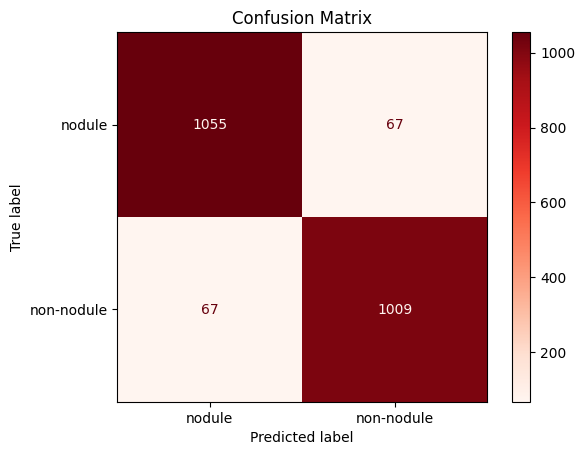

In [ ]:
checkpoint = torch.load(f"weights/{best_model.model_name}.pt", weights_only=False)
best_model.model.load_state_dict(checkpoint['model_state_dict'])
loss = checkpoint["loss"]
print(loss)
best_model.evaluate(test_loader)